In [1]:
from abc import abstractmethod
import inspect
from typing import Tuple
from collections import deque
from copy import deepcopy
import tqdm
from scipy.linalg import solve_discrete_are as dare

import torch
import numpy as np
import jax.numpy as jnp
"""
at the moment DL is in pytorch, once its finalized i can convert to jax for efficiency :)
"""

from models import MLP
from rescalers import FIXED_RESCALE, EMA_RESCALE, ADAM, D_ADAM, DoWG, IDENTITY

def _sigmoid(t):
    return 1 / (1 + np.exp(-t))

def _inv_sigmoid(s):
    return np.log(s / (1 - s + 1e-8))

def _d_sigmoid(t):
    s = _sigmoid(t)
    return s * (1 - s)

def _rescale(t, bounds, use_sigmoid):
    """
    rescales from `[0, 1] -> [tmin, tmax]`
    """
    tmin, tmax = bounds
    if use_sigmoid: t = _sigmoid(t)
    return tmin + (tmax - tmin) * t

def _d_rescale(t, bounds, use_sigmoid):
    tmin, tmax = bounds
    d = tmax - tmin
    if use_sigmoid: d *= _d_sigmoid(t)
    return d

def _inv_rescale(s, bounds, use_sigmoid):
    tmin, tmax = bounds
    t = (s - tmin) / (tmax - tmin)
    if use_sigmoid: t = _inv_sigmoid(t)
    return t

def _generate_uniform(shape, norm=1.00):
    v = np.random.normal(size=shape)
    v = norm * v / np.linalg.norm(v)
    v = jnp.array(v)
    return v

def _exponential_linspace_int(start, end, num, divisible_by=1):
    """Exponentially increasing values of integers."""
    base = np.exp(np.log(end / start) / (num - 1))
    return [int(np.round(start * base**i / divisible_by) * divisible_by) for i in range(num)]

def _append(arr, val):
    """
    rightmost recent appending, i.e. arr = (val_{t-h}, ..., val_{t-1}, val_t)
    """
    if isinstance(arr, torch.Tensor):
        if not isinstance(val, torch.Tensor):
            val = torch.tensor(val, dtype=arr.dtype)
        arr = torch.roll(arr, -1, dims=(0,)).clone()  # have to do it this way for autograd, but its not slower for some reason
        arr[-1] = val
    elif isinstance(arr, jnp.ndarray):
        if not isinstance(val, jnp.ndarray):
            val = jnp.array(val, dtype=arr.dtype)
        arr = arr.at[0].set(val)
        arr = jnp.roll(arr, -1, axis=0)
    return arr

In [2]:
class SystemEstimate:
    """
    Abstract class for system models that predict next "states" from the past `hh` costs and controls.
    It must also be able to map the past `hh` costs and controls to "states".
    Given cost and control histories should be rightmost recent.
    
    This is most useful for getting useful disturbances.
    """
    @abstractmethod
    def __init__(self,
                 hh: int,
                 control_dim: int,
                 state_dim: int):
        self.hh = hh
        self.control_dim = control_dim
        self.state_dim = state_dim
        pass
    
    @abstractmethod
    def get_disturbance(self,
                        cost: float,
                        control: jnp.ndarray,
                        cost_history: jnp.ndarray,
                        control_history: jnp.ndarray) -> jnp.ndarray:
        """
        Given the cost `f(x_t)` received for playing control `u_t`, the cost history `(f(x_{t-hh-1}), ..., f(x_{t-1}))`,
        and the control history `(u_{t-hh-1}, ..., u_{t-1})`, should return the disturbance `w_t`
        """
        raise NotImplementedError('{} not implemented'.format(inspect.stack()[0][3]))
        

        @abstractmethod
    def map(self,
            cost_history: jnp.ndarray,
            control_history: jnp.ndarray) -> jnp.ndarray:
        """
        Maps a history of costs and controls to a "state" (which may just be the cost history or may be a 
        lifted state or anything).
        """
        raise NotImplementedError('{} not implemented'.format(inspect.stack()[0][3]))

    
    @abstractmethod
    def dynamics(self,
                 mapped_state: jnp.ndarray,
                 control: jnp.ndarray) -> jnp.ndarray:
        """
        Predicts what the next "state" will be! this is where you would use system dynamics like
            xhat_{t+1} = A xhat_t + B u_t,
        where xhat denotes the result of mapping the cost and control histories.
        `mapped_state` should be the output of a call to `self.map(fs, us)`
        """
        raise NotImplementedError('{} not implemented'.format(inspect.stack()[0][3]))

    
class NoLift(SystemEstimate):
    def __init__(self,
                 hh: int,
                 control_dim: int):
        super().__init__(hh, control_dim, hh)
        
        self.hh = hh
        self.control_dim = control_dim
        self.state_dim = hh
        
        # linear dynamics estimates
#         self.A = torch.nn.Parameter(torch.eye(self.state_dim, dtype=torch.float32))
#         self.B = torch.nn.Parameter(torch.zeros((self.state_dim, self.control_dim), dtype=torch.float32))

        self.A = torch.nn.Parameter(torch.randn((self.state_dim, self.state_dim), dtype=torch.float32) / (self.state_dim ** 2))
        self.B = torch.nn.Parameter(torch.randn((self.state_dim, self.control_dim), dtype=torch.float32) / (self.state_dim * self.control_dim))
        self.sysid_opt = torch.optim.Adam([self.A, self.B], lr=SYSID_LR)
        pass
    
    def map(self,
            cost_history: jnp.ndarray,
            control_history: jnp.ndarray) -> torch.Tensor:  # TODO make this fully in jax
        """
        maps histories to lifted states. it's in pytorch rn, but that can change
        """
        assert cost_history.shape == (self.hh,)
        assert control_history.shape == (self.hh, self.control_dim)
        
        return torch.from_numpy(np.array(cost_history))


    def dynamics(self,
                 mapped_state: jnp.ndarray,
                 control: jnp.ndarray) -> jnp.ndarray:
        
        assert mapped_state.shape == (self.state_dim,)
        assert control.shape == (self.control_dim,)
        
        control = torch.from_numpy(np.array(control))  # TODO remove this when jax time
        
        return self.A @ mapped_state + self.B @ control
    
    
    def get_disturbance(self,
                        cost: float,
                        control: jnp.ndarray,
                        cost_history: jnp.ndarray,
                        control_history: jnp.ndarray) -> jnp.ndarray:
        """
        Given the cost `f(x_t)` received for playing control `u_t`, the cost history `(f(x_{t-hh-1}), ..., f(x_{t-1}))`,
        and the control history `(u_{t-hh-1}, ..., u_{t-1})`, should return the disturbance `w_t`
        
        `control` should be shape `(control_dim,)`
        `cost_history` should be shape `(hh,)`
        `control_history` should be shape `(hh, control_dim)`
        """        
        
        # estimate next state
        prev_state = self.map(cost_history, control_history)  # xhat_t
        pred_state = self.dynamics(prev_state, control)  # A @ xhat_t + B @ u_t
        
        # compute true next state (note that jax arrays are immutable, so these appends dont affect the arg history arrays)
        true_state = self.map(_append(cost_history, cost), _append(control_history, control))  # xhat_{t+1}
        
        # get disturbance and update system estimate parameters
        disturbance = true_state - pred_state
        
        # TODO change these to jax updates
        self.sysid_opt.zero_grad()
        (disturbance ** 2).sum().backward()  # A, B are best when (A @ xhat_t + B @ u_t) - xhat_{t+1} = 0
        self.sysid_opt.step()
        
        return jnp.array(disturbance.detach().data.numpy())
    
    def get_stabilizing_controller(self):
        # compute stabilizing controller for squared costs
        Q = jnp.eye(self.hh)
        R = jnp.eye(self.control_dim)
        
        A, B = self.A.detach().numpy(), self.B.detach().numpy()
        X = dare(A, B, Q, R)  # solve the ricatti equation
        K = jnp.linalg.inv(B.T @ X @ B + R) @ (B.T @ X @ A)  # compute LQR gain
        return K
    
    

class LinearLift(SystemEstimate):
    def __init__(self,
                 hh: int,
                 control_dim: int,
                 state_dim: int,
                 depth: int):
        super().__init__(hh, control_dim, state_dim)
        
        self.hh = hh
        self.control_dim = control_dim
        self.state_dim = state_dim
        
        # to compute lifted states which hopefully respond linearly to the controls
        flat_dim = hh  # TODO could add control history as an input as well!
        self.lift_model = MLP(layer_dims=_exponential_linspace_int(flat_dim, self.state_dim, depth), use_bias=False).train()
        self.lift_opt = torch.optim.Adam(self.lift_model.parameters(), lr=LIFT_LR)
        
        # linear dynamics estimates
#         self.A = torch.nn.Parameter(torch.eye(self.state_dim, dtype=torch.float32))
#         self.B = torch.nn.Parameter(torch.zeros((self.state_dim, self.control_dim), dtype=torch.float32))
        
        self.A = torch.nn.Parameter(torch.randn((self.state_dim, self.state_dim), dtype=torch.float32) / (self.state_dim ** 2))
        self.B = torch.nn.Parameter(torch.randn((self.state_dim, self.control_dim), dtype=torch.float32) / (self.state_dim * self.control_dim))
        
        self.sysid_opt = torch.optim.Adam([self.A, self.B], lr=SYSID_LR)
        
        self.lift_secant = 0.
        self.sq_lift_secant = 0.
        self.t = 0
        pass
    
    
    def map(self,
            cost_history: jnp.ndarray,
            control_history: jnp.ndarray) -> torch.Tensor:  # TODO make this fully in jax
        """
        maps histories to lifted states. it's in pytorch rn, but that can change
        """
        assert cost_history.shape == (self.hh,)
        assert control_history.shape == (self.hh, self.control_dim)
        
        # convert to pytorch tensors rq
        with torch.no_grad():
            cost_history, control_history = map(lambda j_arr: torch.from_numpy(np.array(j_arr)), [cost_history, control_history])
            state = self.lift_model(cost_history.unsqueeze(0)).squeeze()
            
#         state = jnp.array(state.cpu().data)
        return state


    def dynamics(self,
                 mapped_state: jnp.ndarray,
                 control: jnp.ndarray) -> jnp.ndarray:
        
        assert mapped_state.shape == (self.state_dim,)
        assert control.shape == (self.control_dim,)
        
        control = torch.from_numpy(np.array(control))  # TODO remove this when jax time
        
        return self.A @ mapped_state + self.B @ control
    
    
    def get_disturbance(self,
                        cost: float,
                        control: jnp.ndarray,
                        cost_history: jnp.ndarray,
                        control_history: jnp.ndarray) -> jnp.ndarray:
        """
        Given the cost `f(x_t)` received for playing control `u_t`, the cost history `(f(x_{t-hh-1}), ..., f(x_{t-1}))`,
        and the control history `(u_{t-hh-1}, ..., u_{t-1})`, should return the disturbance `w_t`
        
        `control` should be shape `(control_dim,)`
        `cost_history` should be shape `(hh,)`
        `control_history` should be shape `(hh, control_dim)`
        """        
        # estimate next state
        prev_state = self.map(cost_history, control_history)  # xhat_t
        pred_state = self.dynamics(prev_state, control)  # A @ xhat_t + B @ u_t

        # compute true next state (note that jax arrays are immutable, so these appends dont affect the arg history arrays)
        true_state = self.map(_append(cost_history, cost), _append(control_history, control))  # xhat_{t+1}
        
        # get disturbance and update system estimate parameters
        disturbance = true_state - pred_state
        
        # TODO change these to jax updates
        if self.control_dim == 1 and control != 0:  # update lift transformation to be more linear
            secant = (true_state - self.A @ prev_state) / (torch.from_numpy(np.array(control)) + 1e-8)
            self.lift_secant += secant / STEP_EVERY
            self.sq_lift_secant += secant ** 2 / STEP_EVERY
            if self.t % STEP_EVERY == 0:  # call .backward() on some computation to enforce linear dynamics w.r.t. `control`
                self.lift_opt.zero_grad()
                loss = (self.sq_lift_secant - self.lift_secant ** 2).mean()
                loss.backward()
                self.lift_opt.step()
#                 print(self.lift_secant, self.B.data)
                self.lift_secant = 0.
                self.sq_lift_secant = 0.
        
        self.sysid_opt.zero_grad()
        (disturbance ** 2).mean().backward()  # A, B are best when (A @ xhat_t + B @ u_t) - xhat_{t+1} = 0
        self.sysid_opt.step()
        
        self.t += 1
        
        return jnp.array(disturbance.detach().data.numpy())
    
    def get_stabilizing_controller(self):
        # compute stabilizing controller for squared costs
        Q = jnp.eye(self.state_dim)
        R = jnp.eye(self.control_dim) * 1e-8
        
        A, B = self.A.detach().numpy(), self.B.detach().numpy()
        X = dare(A, B, Q, R)  # solve the ricatti equation
        K = jnp.linalg.inv(B.T @ X @ B + R) @ (B.T @ X @ A)  # compute LQR gain
        return K

In [ ]:
class Hazan(SystemEstimate):
    """
    Description: Identifies unknown matrices A, B of linear dynamical system.
    """

    def __init__(self,
                 state_dim: int,
                 control_dim: int,
                 hh: int,
                 T0: int,  # number of sysid iterations where we explore randomly
                 gamma: float=0.001,  # l2 regularization
                ):
        super().__init__(hh, control_dim, state_dim)
        self.state_dim = state_dim
        self.control_dim = control_dim
        self.hh = hh
        
        self.t = 0
        self.T0 = T0
        self.gamma = gamma
        
        self.xs = jnp.zeros((self.hh, self.state_dim))
        self.etas = jnp.zeros((self.hh, self.control_dim))
        pass
    
    def map(self,
            cost_history: jnp.ndarray,
            control_history: jnp.ndarray) -> torch.Tensor:  # TODO make this fully in jax
        """
        maps histories to lifted states. it's in pytorch rn, but that can change
        """
        assert cost_history.shape == (self.hh,)
        assert control_history.shape == (self.hh, self.control_dim)
        
        # convert to pytorch tensors rq
        with torch.no_grad():
            cost_history, control_history = map(lambda j_arr: torch.from_numpy(np.array(j_arr)), [cost_history, control_history])
            state = self.lift_model(cost_history.unsqueeze(0)).squeeze()
            
#         state = jnp.array(state.cpu().data)
        return state


    def dynamics(self,
                 mapped_state: jnp.ndarray,
                 control: jnp.ndarray) -> jnp.ndarray:
        
        assert mapped_state.shape == (self.state_dim,)
        assert control.shape == (self.control_dim,)
        
        control = torch.from_numpy(np.array(control))  # TODO remove this when jax time
        
        return self.A @ mapped_state + self.B @ control
    
    def get_disturbance(self,
                        cost: float,
                        control: jnp.ndarray,
                        cost_history: jnp.ndarray,
                        control_history: jnp.ndarray) -> jnp.ndarray:
        """
        Given the cost `f(x_t)` received for playing control `u_t`, the cost history `(f(x_{t-hh-1}), ..., f(x_{t-1}))`,
        and the control history `(u_{t-hh-1}, ..., u_{t-1})`, should return the disturbance `w_t`
        
        `control` should be shape `(control_dim,)`
        `cost_history` should be shape `(hh,)`
        `control_history` should be shape `(hh, control_dim)`
        """
        # estimate next state
        prev_state = self.map(cost_history, control_history)  # xhat_t
        pred_state = self.dynamics(prev_state, control)  # A @ xhat_t + B @ u_t

        # compute true next state (note that jax arrays are immutable, so these appends dont affect the arg history arrays)
        true_state = self.map(_append(cost_history, cost), _append(control_history, control))  # xhat_{t+1}
        
        # get disturbance and update system estimate parameters
        disturbance = true_state - pred_state
        
        # TODO change these to jax updates
        if self.control_dim == 1 and control != 0:  # update lift transformation to be more linear
            secant = (true_state - self.A @ prev_state) / (torch.from_numpy(np.array(control)) + 1e-8)
            self.lift_secant += secant / STEP_EVERY
            self.sq_lift_secant += secant ** 2 / STEP_EVERY
            if self.t % STEP_EVERY == 0:  # call .backward() on some computation to enforce linear dynamics w.r.t. `control`
                self.lift_opt.zero_grad()
                loss = (self.sq_lift_secant - self.lift_secant ** 2).mean()
                loss.backward()
                self.lift_opt.step()
#                 print(self.lift_secant, self.B.data)
                self.lift_secant = 0.
                self.sq_lift_secant = 0.
        
        self.sysid_opt.zero_grad()
        (disturbance ** 2).mean().backward()  # A, B are best when (A @ xhat_t + B @ u_t) - xhat_{t+1} = 0
        self.sysid_opt.step()
        
        self.t += 1
        
        return jnp.array(disturbance.detach().data.numpy())
        

    def get_action(self, x_t):
        """ return action """
        self.T += 1
        # regular numpy
        eta_t = 1 - 2*random.randint(2, size=(self.m,)) 
        self.eta.append(eta_t)
        self.x_history.append(np.squeeze(x_t, axis=1))
        return - self.K @ x_t + np.expand_dims(eta_t, axis=1)

    def system_id(self):
        """ returns current estimate of hidden system dynamics """
        assert self.T > 0
        k = self.k if self.k else int(0.15 * self.T)

        # transform eta and x
        eta_np = np.array(self.eta)
        x_np = np.array(self.x_history)

        # prepare vectors and retrieve B
        scan_len = self.T-k-1 # need extra -1 because we iterate over j=0,..,k
        N_j = np.array([np.dot(x_np[j+1:j+1+scan_len].T, eta_np[:scan_len]) for j in range(k+1)]) / scan_len
        B = N_j[0] # np.dot(x_np[1:].T, eta_np[:-1]) / (self.T-1)

        # retrieve A
        C_0, C_1 = N_j[:-1], N_j[1:]
        C_inv = np.linalg.inv(np.tensordot(C_0, C_0, axes=([0,2],[0,2])) + self.gamma * np.identity(self.n))
        A = np.tensordot(C_1, C_0, axes=([0,2],[0,2])) @ C_inv + B @ self.K

        return (A, B)

In [3]:
class Controller:
    def __init__(self,
                 h: int,
                 initial_u: jnp.ndarray,
                 initial_scales: Tuple[float, float, float],
                 sysid: SystemEstimate, 
                 bounds=None,
                 method='FKM'):

        # hyperparams
        self.h = h
        self.hh = sysid.hh
        self.control_dim = initial_u.shape[0]
        self.state_dim = sysid.state_dim
        self.sysid = sysid
        self.method = method; assert self.method in ['FKM', 'REINFORCE']
        self.bounds = bounds
        if self.bounds is not None:
            self.bounds = jnp.array(self.bounds).reshape(2, -1)
            assert len(self.bounds[0]) == len(self.bounds[1]) and len(self.bounds[0]) == self.control_dim, 'improper bounds'
            assert all(map(lambda i: self.bounds[0, i] < self.bounds[1, i], range(self.control_dim))), 'improper bounds'
            self.rescale_u = lambda u: _rescale(u, self.bounds, use_sigmoid=USE_SIGMOID)
            self.inv_rescale_u = lambda ru: _inv_rescale(ru, self.bounds, use_sigmoid=USE_SIGMOID)
            self.d_rescale_u = lambda u: _d_rescale(u, self.bounds, use_sigmoid=USE_SIGMOID)
        else:
            self.rescale_u = lambda u: u
            self.inv_rescale_u = lambda ru: ru
            self.d_rescale_u = lambda u: jnp.ones_like(u)
        
        
        # dynamic parameters of the controller
        self.M = jnp.zeros((self.h, self.control_dim, self.state_dim))
        self.M0 = self.inv_rescale_u(initial_u)
        self.K = jnp.zeros((self.control_dim, self.state_dim))
#         self.K = jnp.array(np.random.randn(self.control_dim, self.state_dim) / (self.control_dim * self.state_dim))
        
        self.M_scale, self.M0_scale, self.K_scale = initial_scales
        self.prev_control = jnp.zeros(self.control_dim)
        self.cost_history = jnp.zeros(self.hh)   # histories are rightmost recent (increasing in time)
        self.control_history = jnp.zeros((self.hh, self.control_dim))
        self.disturbance_history = jnp.zeros((2 * self.h, self.state_dim))  # past 2h disturbances
        self.state_history = jnp.zeros((self.h, self.state_dim))
        self.t = 1

        # grad estimation stuff -- `self.eps` should be divided by its variance!!
        if self.method == 'FKM':
            self.eps_M = jnp.zeros((self.h, self.h, self.control_dim, self.state_dim))  # noise history of M perturbations
            self.eps_M0 = jnp.zeros((self.h, self.control_dim))  # noise history of M0 perturbations
            self.eps_K = jnp.zeros((self.h, self.control_dim, self.state_dim))  # noise history of K perturbations
            
            def grad_M(diff):
                return diff * jnp.sum(self.eps_M, axis=0) * self.control_dim * self.state_dim * self.h
#                 return self.cost_history[-1] * jnp.sum(self.eps, axis=0) * self.control_dim * self.state_dim * self.h
            def grad_M0(diff):
                return diff * jnp.sum(self.eps_M0, axis=0) * self.control_dim * self.state_dim * self.h
#                 return self.cost_history[-1] * jnp.sum(self.eps_bias, axis=0) * self.control_dim * self.state_dim * self.h
            def grad_K(diff):
                return diff * jnp.sum(self.eps_K, axis=0) * self.control_dim * self.state_dim * self.h
#                 return self.cost_history[-1] * jnp.sum(self.eps_bias, axis=0) * self.control_dim * self.state_dim * self.h
            
        elif self.method == 'REINFORCE':
            self.eps = jnp.zeros((self.h + 1, self.control_dim))  # noise history of u perturbations
            
            def grad_M(diff):
#                 val = jnp.tensordot(self.eps[:self.h], self.disturbance_history[-self.h:],
#                                    axes=(0, 0))
                val = 0.
                for i in range(self.h):
                    val += self.eps[i].reshape(self.control_dim, 1) @ self.disturbance_history[-(self.h + i + 1): -(i + 1)].reshape(1, self.h * self.state_dim)
                val = jnp.transpose(val.reshape(self.control_dim, self.h, self.state_dim), (1, 0, 2))
                return diff * val * self.control_dim * self.state_dim * self.h
            def grad_M0(diff):
                return diff * self.eps[-1] * self.control_dim * self.state_dim * self.h
            def grad_K(diff):
                val = 0.
                for i in range(self.h):
                    val += self.eps[i].reshape(self.control_dim, 1) @ self.state_history[i].reshape(1, self.state_dim)
                return diff * val * self.control_dim * self.state_dim * self.h
            
        self.grads = deque(maxlen=self.h)
        self.grad_M = grad_M
        self.grad_M0 = grad_M0
        self.grad_K = grad_K
        
#         self.M_update_rescaler = FIXED_RESCALE(alpha=CONTROLLER_LR, beta=0.9)
#         self.M0_update_rescaler = FIXED_RESCALE(alpha=CONTROLLER_LR, beta=0.9)
#         self.K_update_rescaler = FIXED_RESCALE(alpha=CONTROLLER_LR, beta=0.9)

#         self.M_update_rescaler = ADAM(alpha=M_LR, betas=(0.9, 0.999), use_bias_correction=True)
#         self.M0_update_rescaler = ADAM(alpha=M0_LR, betas=(0.9, 0.999), use_bias_correction=True)
#         self.K_update_rescaler = ADAM(alpha=K_LR, betas=(0.9, 0.999), use_bias_correction=True)
        
#         self.M_update_rescaler = D_ADAM(growth_rate=1.01)
#         self.M0_update_rescaler = D_ADAM(growth_rate=1.01)
#         self.K_update_rescaler = D_ADAM(growth_rate=1.01)
        
        self.M_update_rescaler = M_UPDATE_RESCALER()
        self.M0_update_rescaler = M0_UPDATE_RESCALER()
        self.K_update_rescaler = K_UPDATE_RESCALER()
    
        self.w_rescaler = W_RESCALER()
        pass

    def __call__(self, cost: float) -> jnp.ndarray:
        """
        Returns the control based on current cost and internal parameters.
        """
        
        if self.t == K_TIME:
            self.K = self.sysid.get_stabilizing_controller()
            print('its K time :)')
        
        # observe, compute disturbance (and update sysid), and compute new scale
        disturbance = self.sysid.get_disturbance(cost, self.prev_control, self.cost_history, self.control_history)
        disturbance = self.w_rescaler.step(disturbance)
        cost_diff = cost - self.cost_history[-1]
        M_scale, M0_scale, K_scale = map(lambda s: s, [self.M_scale, self.M0_scale, self.K_scale])
#         M_scale, M0_scale, K_scale = map(lambda s: s / self.t ** 0.25, [self.M_scale, self.M0_scale, self.K_scale])

        # update histories
        self.cost_history = _append(self.cost_history, cost)
        self.control_history = _append(self.control_history, self.prev_control)
        self.disturbance_history = _append(self.disturbance_history, disturbance)
        state = self.sysid.map(self.cost_history, self.control_history)
        self.state_history = _append(self.state_history, state)
        self.t += 1
        
        # update controller
        d = self.d_rescale_u(self.prev_control)
        grad_M = self.grad_M(cost_diff) * d
        grad_M0 = self.grad_M0(cost_diff) * d
        grad_K = self.grad_K(cost_diff) * d
        self.grads.append((grad_M, grad_M0, grad_K))
        if len(self.grads) == self.grads.maxlen:
            grad_M, grad_M0, grad_K = self.grads[0]  # use update from h steps ago
            self.M = self.M - self.M_update_rescaler.step(grad_M, iterate=self.M)
            self.M0 = self.M0 - self.M0_update_rescaler.step(grad_M0, iterate=self.M0)
            self.K = self.K - self.K_update_rescaler.step(grad_K, iterate=self.K)
        
        # compute newest perturbed control
        M_tilde, M0_tilde, K_tilde = self.M, self.M0, self.K
        
        if self.method == 'FKM':
            eps_M = _generate_uniform((self.h, self.control_dim, self.state_dim))
            eps_M0 = _generate_uniform(self.control_dim)
            eps_K = _generate_uniform((self.control_dim, self.state_dim))
            M_tilde = M_tilde + M_scale * eps_M
            M0_tilde = M0_tilde + M0_scale * eps_M0
            K_tilde = K_tilde + K_scale * eps_K
            if M_scale > 0: self.eps_M = _append(self.eps_M, eps_M)
            if M0_scale > 0: self.eps_M0 = _append(self.eps_M0, eps_M0)
            if K_scale > 0: self.eps_K = _append(self.eps_K, eps_K)
            
        elif self.method == 'REINFORCE':
            eps = _generate_uniform(self.control_dim)
            M0_tilde = M0_tilde + M0_scale * eps
            if M0_scale > 0: self.eps = _append(self.eps, eps / M0_scale)
            
        if self.t < T0:
            control = jnp.array(np.random.randn(self.control_dim) * self.M0_scale, dtype=jnp.float32)
        else:
            state = state.detach().data.numpy()
            control = -K_tilde @ state + M0_tilde + jnp.tensordot(M_tilde, self.disturbance_history[-self.h:], axes=([0, 2], [0, 1]))
        control = self.rescale_u(control)
        self.prev_control = control  # cache it
        
        return control

# LDS

In [4]:
class System:
    """
    SYSTEM STATE DEPENDS ON PAST H STATES AND MOST RECENT CONTROL!!!!
    """
    def __init__(self, state_dim, control_dim):
        self.state_dim = state_dim
        self.control_dim = control_dim
        
        done = False
        while not done:
            self.A = torch.randn((state_dim, state_dim))
            w, _ = torch.linalg.eig(self.A)
            done = torch.max(torch.abs(w)) < 1
        
        done = False
        while not done:
            self.B = torch.randn((state_dim, control_dim))
            w, _ = torch.linalg.eig(self.B)
            done = torch.max(torch.abs(w)) < 1
        pass
        
    def step(self, state, control):
        if not isinstance(control, torch.Tensor):
            control = torch.from_numpy(np.array(control))
        if len(control.shape) > 1: control = control.squeeze(-1)
        s = self.A @ state + self.B @ control
        assert s.shape == (self.state_dim,), '{}  {}'.format(s.shape, self.state_dim)
        return s
    pass
  
def cost_fn(x, u):
    if isinstance(x, float):
        x = jnp.array(x)
    elif isinstance(x, torch.Tensor):
        x = jnp.array(x.detach().cpu().data)
    cost = (x ** 2).sum() #+ (u ** 2).sum()
    return cost

def disturbance(t, dim):
    w = np.sin(4 * 2 * np.pi * t / T)
#     w = t
#     w = 1
#     w = 0.1 * np.random.randn()
#     w = 0
    return w * np.ones(dim, dtype=np.float32)

In [5]:
from deluca.agents._gpc import GPC
from deluca.agents._lqr import LQR
from deluca.agents._bpc import BPC

LIFT_LR = 0.00
SYSID_LR = 0.001
CONTROLLER_LR = 0.001

# SEED = 20
K_TIME = 1e6
T = 500
WAIT = 50
STEP_EVERY = 25

du = 1  # control dim
ds = 1
h = 5  # controller memory length (# of w's to use on inference)
hh = 7  # history length of the cost/control histories
lift_dim = 30  # dimension to lift to

METHOD = 'FKM'
INITIAL_SCALES = (0.01, 0.01, 0)  # M, M0, K
BOUNDS = None


# torch.manual_seed(SEED)
sys_init = System(state_dim=ds, control_dim=du)
x_init = 3 * torch.randn(ds, dtype=torch.float32)  # initial state history

# --------------- LQR ------------------------------------------------------

Q = np.identity(ds)
R = np.identity(du) * 1e-8

sys = deepcopy(sys_init)
controller = LQR(A=sys.A.numpy(), B=sys.B.numpy(), Q=Q, R=R)
x = x_init.clone()

xs_lqr = []
costs_lqr = []
print('LQR')
for t in tqdm.trange(T):
    control = controller(x.numpy())
    x = sys.step(x, control) + disturbance(t, ds) 
    xs_lqr.append(x.numpy())
    costs_lqr.append(cost_fn(x, control).item())
    
# ----------------- GPC -----------------------------------------------------------

sys = deepcopy(sys_init)
controller = GPC(A=sys.A.numpy(), B=sys.B.numpy(), Q=Q, R=R, H=h, cost_fn=cost_fn, lr_scale=0.01, decay=False)
x = x_init.clone()

xs_gpc = []
costs_gpc = []
ws_gpc = []
grads_gpc = []
u_decomp_gpc = []
print('GPC')
for t in tqdm.trange(T):
    control = controller(x.numpy().reshape(-1, 1))
    x = sys.step(x, control) + disturbance(t, ds) 
    xs_gpc.append(x.numpy())
    costs_gpc.append(cost_fn(x, control).item())
    ws_gpc.append(jnp.linalg.norm(controller.noise_history[-1]))
    u_decomp_gpc.append((-controller.K @ controller.state,
                        jnp.tensordot(controller.M, controller.last_h_noises(), axes=([0, 2], [0, 1])),
                        jnp.zeros((du, 1))))
    
    
# ---------------- BPC ------------------------------------------------------------
sys = deepcopy(sys_init)
controller = BPC(A=sys.A.numpy(), B=sys.B.numpy(), Q=Q, R=R, H=h, lr_scale=0.005, delta=0.01)
x = x_init.clone()

xs_bpc = []
costs_bpc = []
ws_bpc = []
grads_bpc = []
u_decomp_bpc = []
print('BPC')
for t in tqdm.trange(T):
    cost = cost_fn(x, control).item()
    control = controller(x.numpy().reshape(-1, 1), cost)
    x = sys.step(x, control) + disturbance(t, ds) 
    xs_bpc.append(x.numpy())
    costs_bpc.append(cost)
    ws_bpc.append(jnp.linalg.norm(controller.noise_history[-1]))
    u_decomp_bpc.append((-controller.K @ controller.state,
                    jnp.tensordot(controller.M, controller.noise_history, axes=([0, 2], [0, 1])),
                    jnp.zeros((du, 1))))
    
# --------------- BPC NOLIFT ------------------------------------------------------

controller = Controller(h, initial_u=jnp.zeros(du), sysid=NoLift(hh, du), bounds=BOUNDS, method=METHOD, initial_scales=INITIAL_SCALES)
sys = deepcopy(sys_init)
x = x_init.clone()

xs_bpc_nolift = []
costs_bpc_nolift = []
ws_bpc_nolift = []
grads_bpc_nolift = []
u_decomp_bpc_nolift = []
print('BPC NOLIFT')
for t in tqdm.trange(T):
    cost = cost_fn(x, control).item()
    control = controller(cost)
    x = sys.step(x, control) + disturbance(t, ds) 
    xs_bpc_nolift.append(x.numpy())
    costs_bpc_nolift.append(cost)
    ws_bpc_nolift.append(jnp.linalg.norm(controller.disturbance_history[-1]))
    grads_bpc_nolift.append(jnp.linalg.norm(controller.grads[0][1]))
    u_decomp_bpc_nolift.append((-controller.K @ controller.sysid.map(controller.cost_history, controller.control_history).detach().data.numpy(),
                               jnp.tensordot(controller.M, controller.disturbance_history[-controller.h:], axes=([0, 2], [0, 1])),
                               controller.M0))
    
# --------------- BPC LIFT ------------------------------------------------------

controller = Controller(h, initial_u=jnp.zeros(du), sysid=LinearLift(hh, du, lift_dim, depth=8), bounds=BOUNDS, method=METHOD, initial_scales=INITIAL_SCALES)
sys = deepcopy(sys_init)
x = x_init.clone()

xs_bpc_lift = []
costs_bpc_lift = []
ws_bpc_lift = []
grads_bpc_lift = []
u_decomp_bpc_lift = []
print('BPC LIFT')
for t in tqdm.trange(T):
    cost = cost_fn(x, control).item()
    control = controller(cost)
    x = sys.step(x, control) + disturbance(t, ds)
    xs_bpc_lift.append(x.numpy())
    costs_bpc_lift.append(cost)
    ws_bpc_lift.append(jnp.linalg.norm(controller.disturbance_history[-1]))
    grads_bpc_lift.append(jnp.linalg.norm(controller.grads[0][1]))
    u_decomp_bpc_lift.append((-controller.K @ controller.sysid.map(controller.cost_history, controller.control_history).detach().data.numpy(),
                           jnp.tensordot(controller.M, controller.disturbance_history[-controller.h:], axes=([0, 2], [0, 1])),
                           controller.M0))

    
import matplotlib.pyplot as plt

fig, ax = plt.subplots(4, 2, figsize=(16, 24))

# plot lqr
xs_lqr = np.array(xs_lqr).squeeze()
ax[0, 0].plot(range(T), xs_lqr, label='lqr')
ax[0, 1].plot(range(T), costs_lqr, label='lqr')

# plot gpc
xs_gpc = np.array(xs_gpc).squeeze()
ws_gpc = np.array(ws_gpc).squeeze()
u_decomp_gpc = np.array(u_decomp_gpc).squeeze()
ax[0, 0].plot(range(T), xs_gpc, label='gpc')
ax[0, 1].plot(range(T), costs_gpc, label='gpc')
ax[1, 0].plot(range(T), ws_gpc, label='gpc')
# ax[1, 1].plot(range(T), grads_gpc, label='gpc')
ax[2, 0].plot(range(T), u_decomp_gpc[:, 0], label='K @ state')
ax[2, 0].plot(range(T), u_decomp_gpc[:, 1], label='M \cdot w')
ax[2, 0].plot(range(T), u_decomp_gpc[:, 2], label='M0')

# plot bpc
xs_bpc = np.array(xs_bpc).squeeze()
ws_bpc = np.array(ws_bpc).squeeze()
u_decomp_bpc = np.array(u_decomp_bpc).squeeze()
ax[0, 0].plot(range(T), xs_bpc, label='bpc')
ax[0, 1].plot(range(T), costs_bpc, label='bpc')
ax[1, 0].plot(range(T), ws_bpc, label='bpc')
# ax[1, 1].plot(range(T), grads_bpc, label='bpc')
ax[2, 1].plot(range(T), u_decomp_bpc[:, 0], label='K @ state')
ax[2, 1].plot(range(T), u_decomp_bpc[:, 1], label='M \cdot w')
ax[2, 1].plot(range(T), u_decomp_bpc[:, 2], label='M0')

# plot bpc nolift
xs_bpc_nolift = np.array(xs_bpc_nolift).squeeze()
ws_bpc_nolift = np.array(ws_bpc_nolift).squeeze()
u_decomp_bpc_nolift = np.array(u_decomp_bpc_nolift).squeeze()
ax[0, 0].plot(range(T), xs_bpc_nolift, label='bpc nolift')
ax[0, 1].plot(range(T), costs_bpc_nolift, label='bpc nolift')
ax[1, 0].plot(range(T), ws_bpc_nolift, label='bpc nolift')
ax[1, 1].plot(range(T), grads_bpc_nolift, label='bpc nolift')
ax[3, 0].plot(range(T), u_decomp_bpc_nolift[:, 0], label='K @ state')
ax[3, 0].plot(range(T), u_decomp_bpc_nolift[:, 1], label='M \cdot w')
ax[3, 0].plot(range(T), u_decomp_bpc_nolift[:, 2], label='M0')

# plot bpc lift
xs_bpc_lift = np.array(xs_bpc_lift).squeeze()
ws_bpc_lift = np.array(ws_bpc_lift).squeeze()
u_decomp_bpc_lift = np.array(u_decomp_bpc_lift).squeeze()
ax[0, 0].plot(range(T), xs_bpc_lift, label='bpc lift')
ax[0, 1].plot(range(T), costs_bpc_lift, label='bpc lift')
ax[1, 0].plot(range(T), ws_bpc_lift, label='bpc lift')
ax[1, 1].plot(range(T), grads_bpc_lift, label='bpc lift')
ax[3, 1].plot(range(T), u_decomp_bpc_lift[:, 0], label='K @ state')
ax[3, 1].plot(range(T), u_decomp_bpc_lift[:, 1], label='M \cdot w')
ax[3, 1].plot(range(T), u_decomp_bpc_lift[:, 2], label='M0')

ax[0, 0].plot(range(T), [0. for _ in range(T)], label='opt')
ax[0, 0].set_title('position'); ax[0, 0].legend(); ax[0, 0].set_ylim(-2, 2)
ax[0, 1].set_title('cost'); ax[0, 1].legend(); ax[0, 1].set_ylim(-2, 2)
ax[1, 0].set_title('disturbances'); ax[1, 0].legend();# ax[1, 0].set_ylim(0, 2)
ax[1, 1].set_title('M0 grads'); ax[1, 1].legend()
ax[2, 0].set_title('K @ state, M \cdot w, and M_0 for GPC'); ax[2, 0].legend()
ax[2, 1].set_title('K @ state, M \cdot w, and M_0 for BPC'); ax[2, 1].legend()
ax[3, 0].set_title('K @ state, M \cdot w, and M_0 for BPC NOLIFT'); ax[3, 0].legend()
ax[3, 1].set_title('K @ state, M \cdot w, and M_0 for BPC LIFT'); ax[3, 1].legend()

plt.show()

LQR


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:00<00:00, 1832.57it/s]


GPC


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 363.59it/s]


BPC


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:01<00:00, 360.42it/s]


NameError: name 'M_UPDATE_RESCALER' is not defined

# COCO BBOB

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:10<00:00, 185.24it/s]


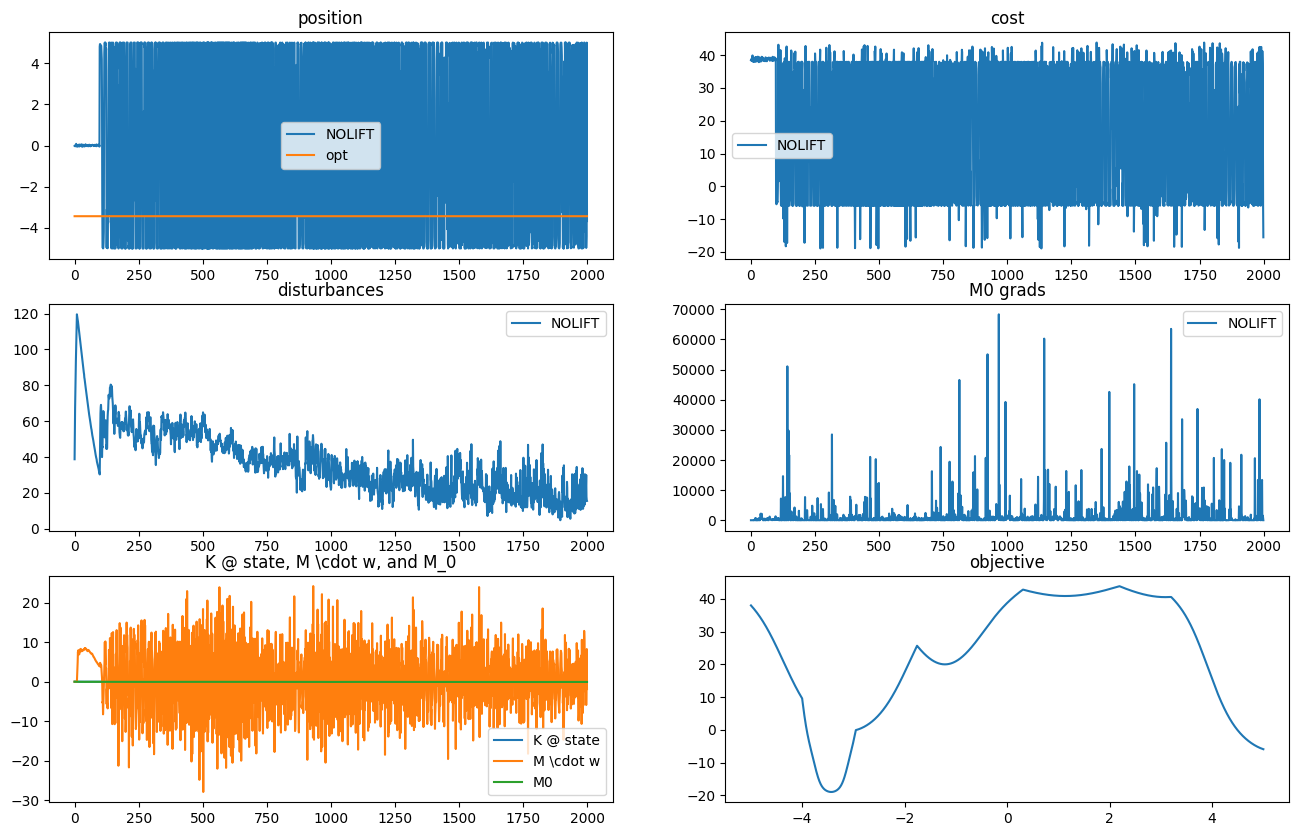

In [33]:
from dynamical_systems import COCO

USE_SIGMOID = True

LIFT_LR = 0
SYSID_LR = 0.001

M_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))
M0_UPDATE_RESCALER = lambda : ADAM(0.001, betas=(0.9, 0.999))
K_UPDATE_RESCALER = lambda : ADAM(0, betas=(0.999, 0.999))

W_RESCALER = lambda : IDENTITY()
# W_RESCALER = lambda : EMA_RESCALE(beta=0.99)
# W_RESCALER = lambda : ADAM(betas=(0.9, 0.9))

K_TIME = 1e6
T = 2000  # total
T0 = 1000  # for sysid
STEP_EVERY = 25

du = 1  # control dim
ds = 1
h = 10  # controller memory length (# of w's to use on inference)
hh = 10  # length of the cost/control histories
lift_dim = 30  # dimension to lift to

METHOD = 'FKM'  # 'FKM', 'REINFORCE'
INITIAL_SCALES = (0.01, 0.01, 0)  # M, M0, K (for REINFORCE the scale is the M0 one)
BOUNDS = (-5, 5)

method = 'NOLIFT'  # 'NOLIFT', 'LIFT'
problem_number = 683
u_index = 0
predict_differences = False


# ------------------------------------------------------------------------------------------------------------------

sysid = NoLift(hh, du) if method == 'NOLIFT' else LinearLift(hh, du, lift_dim, depth=3)
controller = Controller(h, initial_u=jnp.zeros(du), sysid=sysid, bounds=BOUNDS, method=METHOD, initial_scales=INITIAL_SCALES)
sys = COCO(index=problem_number, u_index=u_index, predict_differences=predict_differences)
cost = sys.interact(0.)

xs = []
costs = []
ws = []
grads = []
u_decomp = []
for t in tqdm.trange(T):
    control = controller(cost)
    cost = sys.interact(control)
    
    xs.append(sys.x[sys.u_index])
    costs.append(cost)
    ws.append(jnp.linalg.norm(controller.disturbance_history[-1]))
    grads.append(jnp.linalg.norm(controller.grads[0][1]))
    u_decomp.append((-controller.K @ controller.sysid.map(controller.cost_history, controller.control_history).detach().data.numpy(),
                   jnp.tensordot(controller.M, controller.disturbance_history[-controller.h:], axes=([0, 2], [0, 1])),
                   controller.M0))
    

import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 2, figsize=(16, 10))
u_decomp = np.array(u_decomp)

# plot 
ax[0, 0].plot(range(T), xs, label=method)
ax[0, 1].plot(range(T), costs, label=method)
ax[1, 0].plot(range(T), ws, label=method)
ax[1, 1].plot(range(T), grads, label=method)

ax[0, 0].plot(range(T), [sys.stats['optimal_control']['value'] for _ in range(T)], label='opt')
ax[0, 0].set_title('position'); ax[0, 0].legend()
ax[0, 1].set_title('cost'); ax[0, 1].legend()
ax[1, 0].set_title('disturbances'); ax[1, 0].legend()
ax[1, 1].set_title('M0 grads'); ax[1, 1].legend()

ax[2, 0].plot(range(T), u_decomp[:, 0], label='K @ state')
ax[2, 0].plot(range(T), u_decomp[:, 1], label='M \cdot w')
ax[2, 0].plot(range(T), u_decomp[:, 2], label='M0')
ax[2, 0].set_title('K @ state, M \cdot w, and M_0'); ax[2, 0].legend()

us, fs = sys.stats['gt_controls']['value'], sys.stats['gt_values']['value']
ax[2, 1].plot(us, fs)
ax[2, 1].set_title('objective')

plt.show()